In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns

import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


from sklearn.datasets import fetch_openml

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import  SubsetRandomSampler  #for validation test
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [2]:
def get_fc(inp_dim, out_dim, non_linear='relu'):
    """
    Mid-level API. It is useful to customize your own for large code repo.
    :param inp_dim: int, intput dimension
    :param out_dim: int, output dimension
    :param non_linear: str, 'relu', 'softmax'
    :return: list of layers [FC(inp_dim, out_dim), (non linear layer)]
    """
    layers = []
    layers.append(nn.Linear(inp_dim, out_dim))
    if non_linear == 'relu':
        layers.append(nn.ReLU())
    elif non_linear == 'softmax':
        layers.append(nn.Softmax(dim=1))
    elif non_linear == 'none':
        pass
    else:
        raise NotImplementedError
    return layers

In [3]:
class SimpleCNN(nn.Module):
    """
    Model definition
    """
    def __init__(self, num_classes=10, inp_size=28, c_dim=1):
        super().__init__()
        self.num_classes = num_classes
        #add layer one by one -- one way to add layers
        self.conv1 = nn.Conv2d(c_dim, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.nonlinear = nn.ReLU(inplace = False)                
        self.pool1 = nn.AvgPool2d(2, 2)
        self.pool2 = nn.AvgPool2d(2, 2)

        self.flat_dim = int((inp_size*inp_size*64)/16)
        self.fc1 = nn.Sequential(*get_fc(self.flat_dim, 128, 'relu'))
        self.fc2 = nn.Sequential(*get_fc(128, num_classes, 'none'))

    def forward(self, x):
        """
        :param x: input image in shape of (N, C, H, W)
        :return: out: classification logits in shape of (N, Nc)
        """
        N = x.size(0)        
        x = self.conv1(x)        
        x = self.nonlinear(x)        
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.nonlinear(x)
        x = self.pool2(x)

        #check the dimension of input here
       # print("size",x.shape)
        flat_x = x.view(N,self.flat_dim)
        out = self.fc1(flat_x)
        out = self.fc2(out)   
        
        return out

In [4]:
class FMNISTDatapy(Dataset):

    def __init__(self,x_data,y_data, train=True):
        #x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=4)
        
       
        if train:
        #print(np.max(x_data))
        #print(np.max(y_data))
            self.x_data, self.y_data = torch.from_numpy(x_data), torch.from_numpy(y_data)
            print(type(self.x_data))
            print(len(self.x_data))
        else:
            self.x_data, self.y_data = torch.from_numpy(x_data), torch.from_numpy(y_data)

    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, i):
        return self.x_data[i], self.y_data[i]

In [5]:
fmnist_data = fetch_openml(name ="Fashion-MNIST")
fmnistData = fmnist_data.data.to_numpy()
fmnistTarget = fmnist_data.target.to_numpy()
#fmnistTarget = np.expand_dims(fmnistTarget, axis = 1)
fmnistTarget = fmnistTarget.astype(int)
x_train, x_test, y_train, y_test = train_test_split(fmnistData, fmnistTarget, test_size=0.2, train_size=0.8, random_state=42)

In [6]:
np.shape(x_test)

(14000, 784)

In [7]:
# DataLoader stuff
trainloader = DataLoader(FMNISTDatapy(x_train,y_train,train=True),batch_size=32)
testloader  = DataLoader(FMNISTDatapy(x_test,y_test,train=False))

# CNN stuff
epochs = 5
# learning rate
lr = 1e-4
# Learning rate step gamma
gamma = 1.0
batch_size = 32
# set true if using GPU during training
#use_cuda = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = SimpleCNN()
net = net.float()
net.to(device)
net.train()

criterion = nn.CrossEntropyLoss()    # combines a logSoftMax                                   


optimizer = torch.optim.Adam(net.parameters(), lr)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma = gamma)

# Calculate accuracy before training
correct = 0
total = 0
#Plotting stuff

log_every = 100
cnt = 0
train_log = {'iter': [], 'loss': [], 'accuracy': []}

# Iterate through train dataset
for epoch in range(epochs):
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.reshape([32,1,28,28])
        
        # print(type(images))      
        # warp input images in a Variable wrapper
        images = Variable(images)
        optimizer.zero_grad()
        outputs = net(images.float())
        # Calculate the loss
        loss = F.cross_entropy(outputs,labels.long())
        # Calculate gradient w.r.t the loss
        loss.backward()
        # Optimizer takes one step
        optimizer.step()
        # Log info
        if cnt % log_every == 0:
            print('Train Epoch: {} [{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, cnt, len(trainloader.dataset),
                       loss.item()))
            train_log['iter'].append(cnt)
            train_log['loss'].append(loss.cpu().detach().numpy())
            #get the predicted class from the maximum value in the output-list of class scores
            pred = outputs.argmax(dim=1, keepdim=True)
            correct = pred.eq(labels.view_as(pred)).sum().item()
            train_acc =  correct/batch_size
            train_log['accuracy'].append(train_acc)
        cnt += 1

    # calculate the accuracy
    #scheduler.step()
    #if epoch%10 == 0:
    print(train_acc)


<class 'torch.Tensor'>
56000
Train Epoch: 0 [0 (56000%)]	Loss: 7.502061
Train Epoch: 0 [100 (56000%)]	Loss: 0.542517
Train Epoch: 0 [200 (56000%)]	Loss: 0.360094
Train Epoch: 0 [300 (56000%)]	Loss: 0.625939
Train Epoch: 0 [400 (56000%)]	Loss: 0.734730
Train Epoch: 0 [500 (56000%)]	Loss: 0.488602
Train Epoch: 0 [600 (56000%)]	Loss: 0.798847
Train Epoch: 0 [700 (56000%)]	Loss: 0.583655
Train Epoch: 0 [800 (56000%)]	Loss: 0.381804
Train Epoch: 0 [900 (56000%)]	Loss: 0.533259
Train Epoch: 0 [1000 (56000%)]	Loss: 0.305066
Train Epoch: 0 [1100 (56000%)]	Loss: 0.168527
Train Epoch: 0 [1200 (56000%)]	Loss: 0.301914
Train Epoch: 0 [1300 (56000%)]	Loss: 0.285105
Train Epoch: 0 [1400 (56000%)]	Loss: 0.239867
Train Epoch: 0 [1500 (56000%)]	Loss: 0.343784
Train Epoch: 0 [1600 (56000%)]	Loss: 0.323056
Train Epoch: 0 [1700 (56000%)]	Loss: 0.389336
0.875
Train Epoch: 1 [1800 (56000%)]	Loss: 0.419120
Train Epoch: 1 [1900 (56000%)]	Loss: 0.661881
Train Epoch: 1 [2000 (56000%)]	Loss: 0.401049
Train Epoch

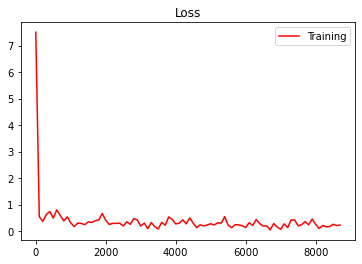

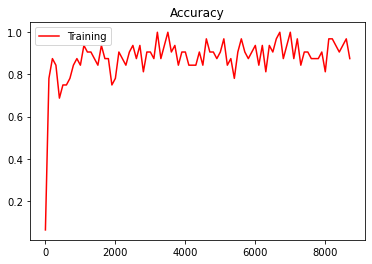

In [8]:
fig = plt.figure()
plt.plot(train_log['iter'], train_log['loss'], 'r', label='Training')
plt.title('Loss')
plt.legend()
fig = plt.figure()
plt.plot(train_log['iter'], train_log['accuracy'], 'r', label='Training')
plt.title('Accuracy')
plt.legend()
plt.show()

In [9]:
def test(model, device, test_loader):
    """Evaluate model on test dataset."""
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.reshape([1,1,28,28])  
            data = Variable(data)
            data, target = data.to(device), target.to(device)
            output = model(data.float())
            test_loss += F.cross_entropy(output, target.long(), reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, correct / len(test_loader.dataset)

In [10]:
test(net, device, testloader)


Test set: Average loss: 0.2575, Accuracy: 12728/14000 (91%)



(0.2575317470849978, 0.9091428571428571)

In [11]:
# SVM stuff
svmCLF = SVC()
svmCLF.fit(x_train, y_train)

SVC()

In [12]:
y_pred = svmCLF.predict(x_test)

In [13]:
print(f"SVM Model Accuracy:{svmCLF.score(x_test, y_test)}")

SVM Model Accuracy:0.8887857142857143


In [14]:
np.random.seed(8675309)
gauss_noise = np.random.normal(0,10, (14000, 784))
x_test_gauss = x_test + gauss_noise
x_test_speckle = x_test + x_test*gauss_noise*0.05 

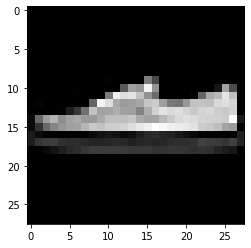

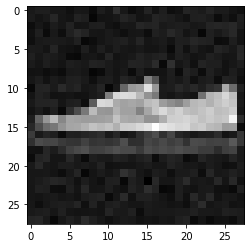

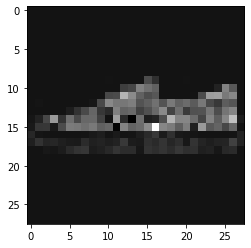

In [15]:
imc = 1
plt.imshow(x_test[imc,:].reshape(28,28), cmap = 'gray')
plt.show()
plt.imshow(x_test_gauss[imc,:].reshape(28,28), cmap = 'gray')
plt.show()
plt.imshow(x_test_speckle[imc,:].reshape(28,28), cmap = 'gray')
plt.show()

In [16]:
y_pred_gauss = svmCLF.predict(x_test_gauss)
print(f"SVM Model Accuracy:{svmCLF.score(x_test_gauss, y_test)}")

SVM Model Accuracy:0.8891428571428571


In [17]:
y_pred_speckle = svmCLF.predict(x_test_speckle)
print(f"SVM Model Accuracy:{svmCLF.score(x_test_speckle, y_test)}")

SVM Model Accuracy:0.7947142857142857


In [18]:
gaussloader  = DataLoader(FMNISTDatapy(x_test_gauss,y_test,train=False))
speckleloader  = DataLoader(FMNISTDatapy(x_test_speckle,y_test,train=False))

In [19]:
test(net, device, gaussloader)


Test set: Average loss: 0.2837, Accuracy: 12590/14000 (90%)



(0.28368166751199586, 0.8992857142857142)

In [20]:
test(net, device, speckleloader)


Test set: Average loss: 0.9296, Accuracy: 10555/14000 (75%)



(0.9296168071685936, 0.7539285714285714)

In [21]:
# SVM stuff
#from sklearn.svm import LinearSVC
rbfCLF = SVC(kernel='rbf')
rbfCLF.fit(x_train, y_train)

SVC()

In [22]:
y_pred_rbf = rbfCLF.predict(x_test)
print(f"SVM Model Accuracy:{rbfCLF.score(x_test, y_test)}")

SVM Model Accuracy:0.8887857142857143


In [23]:
y_pred_rbfg = rbfCLF.predict(x_test_gauss)
print(f"SVM Model Accuracy:{rbfCLF.score(x_test_gauss, y_test)}")

SVM Model Accuracy:0.8891428571428571


In [24]:
y_pred_rbfs = rbfCLF.predict(x_test_speckle)
print(f"SVM Model Accuracy:{rbfCLF.score(x_test_speckle, y_test)}")

SVM Model Accuracy:0.7947142857142857


In [25]:
polyCLF = SVC(kernel='poly')
polyCLF.fit(x_train, y_train)

SVC(kernel='poly')

In [26]:
y_pred_poly = polyCLF.predict(x_test)
print(f"SVM Model Accuracy:{polyCLF.score(x_test, y_test)}")

SVM Model Accuracy:0.8702857142857143


In [27]:
y_pred_polyg = polyCLF.predict(x_test_gauss)
print(f"SVM Model Accuracy:{polyCLF.score(x_test_gauss, y_test)}")

SVM Model Accuracy:0.8696428571428572


In [28]:
y_pred_polys = polyCLF.predict(x_test_speckle)
print(f"SVM Model Accuracy:{polyCLF.score(x_test_speckle, y_test)}")

SVM Model Accuracy:0.8186428571428571


In [29]:
bestCLF = SVC(kernel='rbf', C=5)
bestCLF.fit(x_train, y_train)

SVC(C=5)

In [30]:
y_pred_b = bestCLF.predict(x_test)
print(f"SVM Model Accuracy:{bestCLF.score(x_test, y_test)}")

SVM Model Accuracy:0.903


In [31]:
y_pred_bg = bestCLF.predict(x_test_gauss)
print(f"SVM Model Accuracy:{bestCLF.score(x_test_gauss, y_test)}")

SVM Model Accuracy:0.9029285714285714


In [33]:
y_pred_bs = bestCLF.predict(x_test_speckle)
print(f"SVM Model Accuracy:{bestCLF.score(x_test_speckle, y_test)}")

SVM Model Accuracy:0.7577857142857143


In [34]:
from sklearn.decomposition import PCA

# Calculate means
x_train_mean = x_train.mean(axis=0)
x_train_nm = x_train - x_train_mean

# Initialize PCA object
pca = PCA(n_components=2)

# Fit PCA to normalized data with no components
Z = pca.fit_transform(x_train_nm)

# Principal Components
V = pca.components_

# First and second PC
Z_x = Z[0]
Z_y = Z[1]

# Standard deviations of both components
std_x = np.std(Z_x)
std_y = np.std(Z_y)

# Grid parameters
x_min, x_max = -5*std_x, 5*std_x
y_min, y_max = -5*std_y, 5*std_y
x_step = std_x/20
y_step = std_y/20

xx, yy = np.meshgrid(np.arange(x_min, x_max, x_step), np.arange(y_min, y_max, y_step))

# Projected points into PC plane
z = np.c_[xx.ravel(), yy.ravel()]

# Revert projection
x = np.dot(z,V)

In [35]:
predictions = bestCLF.predict(x)
predictions = predictions.reshape(xx.shape)

/local_scratch/pbs.4952583.pbs02/ipykernel_3391349/15765804.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  clb = plt.colorbar(contour, boundaries=list(np.unique(predictions)),


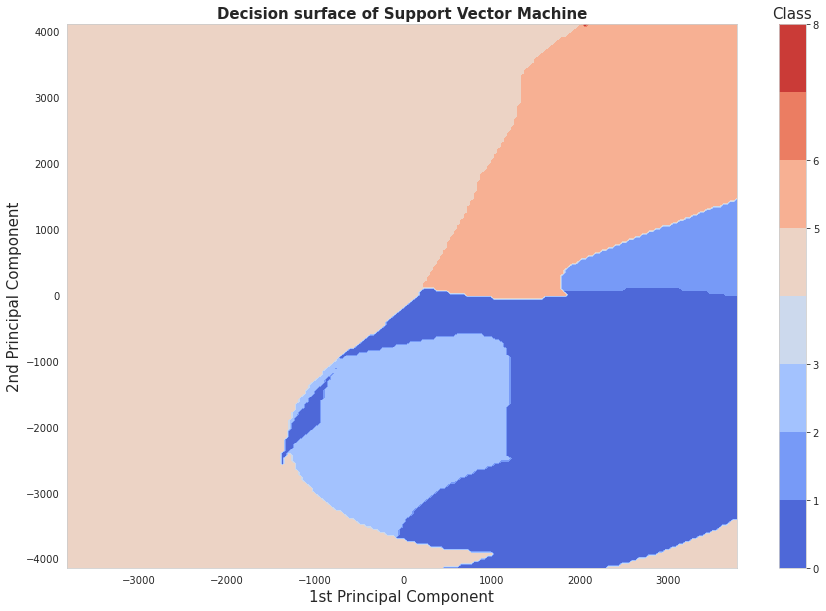

In [37]:
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize = (15,10))
contour = plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm)
clb = plt.colorbar(contour, boundaries=list(np.unique(predictions)),
                        ticks=list(np.unique(predictions)),spacing='proportional')
clb.ax.set_title('Class', fontsize=15)
plt.xlabel('1st Principal Component', fontsize = 15)
plt.ylabel('2nd Principal Component', fontsize = 15)
plt.title("Decision surface of Support Vector Machine", fontweight = 'bold', fontsize=15)
plt.savefig("full-setSVM.png")